# Facial Expression Recognition

This is a kaggle challenge. We want to predict people’s emotion via
their face images. The inputs are 48x48 pixel gray-scale images with one face in
each image, the outputs are facial expressions which are categorized from one of
seven types of emotion (0: Anger, 1: Disgust, 2: Fear, 3: Happy, 4: Sadness, 5:
Surprise, 6: Neutral).

# Dataset

The training set consists of 28709 pairs (image & label). The testing set consists
of 3589 pairs. All are stored in “csv" file of 2 columns: emotion (number from 0
to 6) and pixels (string contains value of pixel in an image).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.models import load_model, model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import random

# 1. Data preprocessing

In [3]:
df = pd.read_csv('/content/drive/My Drive/Facial_Expression_Recognition/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Distribution of classes

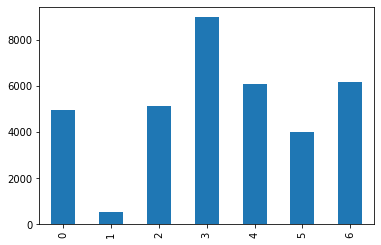

In [4]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

dis_emo = df['emotion'].value_counts(sort = False)
dis_emo.plot(kind = 'bar')

## Replace "Disgust" by "Angry"

Due to the number of "Disgust" images is very small compared with other classes. Therefore it can cause the imbalanced classes problem. In addition,  Angry face looks similar to Disgust faces. Thus, we replace "Disgust" label by "Angry" label. Finally, we solve the the facial expression recognition of six emotions: ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [5]:
df['six_emotion'] = df['emotion'].apply(lambda x: 0 if x == 1 else x)

## Convert string pixels into numpy array

In [6]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

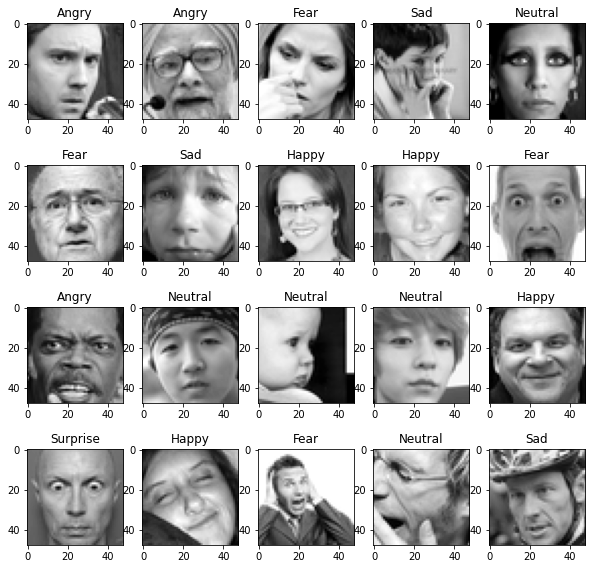

In [7]:
# show some images
showed_imgs = df['pixels'][0:20]
showed_label = df['six_emotion'][0:20]

fig=plt.figure(figsize=(10,10))
rows=4
colums=5
for i in range(20):
    img = showed_imgs[i]
    ax = plt.subplot(rows,colums,i+1)
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(emo[showed_label[i]])
plt.show() 

## Train Test Data

In [8]:
X_train = np.stack(df[df['Usage'] == "Training"]['pixels'], axis = 0)
y_train = np.stack(df[df['Usage'] == "Training"]['six_emotion'], axis = 0)

X_testPub = np.stack(df[df['Usage'] == "PublicTest"]['pixels'], axis = 0)
y_testPub = np.stack(df[df['Usage'] == "PublicTest"]['six_emotion'], axis = 0)

X_testPrivate = np.stack(df[df['Usage'] == "PrivateTest"]['pixels'], axis = 0)
y_testPrivate = np.stack(df[df['Usage'] == "PrivateTest"]['six_emotion'], axis = 0)

# categorical labels
le = LabelEncoder()
le.fit(df['six_emotion'])
y_train = to_categorical(le.transform(y_train))
y_testPub = to_categorical(le.transform(y_testPub))
y_testPrivate = to_categorical(le.transform(y_testPrivate))

# Normalize 
X_train = X_train/255.0
X_testPub = X_testPub/255.0
X_testPrivate = X_testPrivate/255.0

In [9]:
print("X_train: {}".format(X_train.shape))
print("X_testPub: {}".format(X_testPub.shape))
print("X_testPrivate: {}".format(X_testPrivate.shape))
print("y_train: {}".format(y_train.shape))
print("y_testPub: {}".format(y_testPub.shape))
print("y_testPrivate: {}".format(y_testPrivate.shape))


X_train: (28709, 48, 48, 1)
X_testPub: (3589, 48, 48, 1)
X_testPrivate: (3589, 48, 48, 1)
y_train: (28709, 6)
y_testPub: (3589, 6)
y_testPrivate: (3589, 6)


## Train Val Split

We will use public set as validation set and use private set to evaluate model

In [10]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, stratify=y_train,
#                                                     test_size=0.2, random_state=1234)

## 2. Model Architecture

In [12]:
width = 48
height = 48
num_features = 64
num_labels = 6
        
model = Sequential()
model.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'relu', input_shape = (width, height, 1), padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size =(3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(8*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(4*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation = 'softmax'))

model.summary()
model.compile(loss = categorical_crossentropy,
             optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [13]:
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5", verbose=0, save_best_only=True)

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
              verbose = 1, validation_data = (X_testPub, y_testPub), shuffle = True, callbacks = [early_stopping, checkpointer])

#saving the  model to be used later
model_json = model.to_json()
with open("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")

Epoch 1/100
898/898 [==============================] - 19s 22ms/step - loss: 1.9795 - accuracy: 0.2220 - val_loss: 1.7480 - val_accuracy: 0.2494
Epoch 2/100
898/898 [==============================] - 18s 20ms/step - loss: 1.7540 - accuracy: 0.2494 - val_loss: 1.8326 - val_accuracy: 0.2494
Epoch 3/100
898/898 [==============================] - 19s 21ms/step - loss: 1.6801 - accuracy: 0.2737 - val_loss: 1.6444 - val_accuracy: 0.2870
Epoch 4/100
898/898 [==============================] - 19s 21ms/step - loss: 1.5435 - accuracy: 0.3578 - val_loss: 1.4072 - val_accuracy: 0.4210
Epoch 5/100
898/898 [==============================] - 19s 21ms/step - loss: 1.4591 - accuracy: 0.3959 - val_loss: 1.3286 - val_accuracy: 0.4642
Epoch 6/100
898/898 [==============================] - 18s 20ms/step - loss: 1.4043 - accuracy: 0.4161 - val_loss: 1.3498 - val_accuracy: 0.4497
Epoch 7/100
898/898 [==============================] - 18s 20ms/step - loss: 1.3716 - accuracy: 0.4293 - val_loss: 1.4784 - val_ac

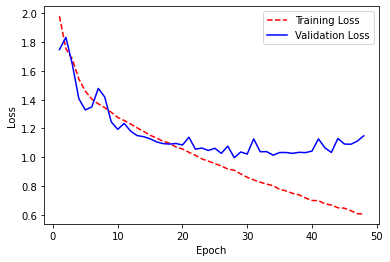

In [14]:

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 3. Evaluation

In [15]:
with open ("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")



# # test on Public-test dataset
# print('Test performance in Public set')
# y_pre = loaded_model.predict(X_testPub)
# print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))
# print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))

# test on Private-test dataset
print('Test performance in Private set')
y_pre = loaded_model.predict(X_testPrivate)

print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1)))
print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1) ))

Test performance in Private set
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       443
           1       0.31      0.50      0.38       330
           2       0.85      0.87      0.86       859
           3       0.61      0.45      0.52       813
           4       0.73      0.81      0.77       374
           5       0.72      0.58      0.64       770

    accuracy                           0.64      3589
   macro avg       0.62      0.64      0.62      3589
weighted avg       0.66      0.64      0.65      3589

0.6427974366118696


# Data augmentation

We realize that our dataset is quit small, therefore we try to use ImageDataGenerator to generate more data. This can increase the performance of model. We wil examine it by camparing with the previous model.

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



In [39]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

sample_img = X_train[0].reshape(1,48,48,1)
datagen.fit(sample_img)
num_batches = 19
generated_sample = sample_img

for images in datagen.flow(sample_img, batch_size = 1):
    if (num_batches == 0):
        break
    generated_sample = np.append(generated_sample, images, axis=0)
    num_batches = num_batches - 1

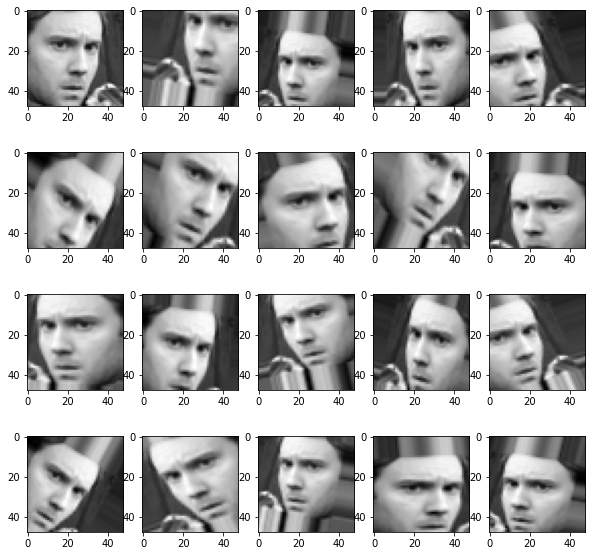

In [40]:
# show some images
showed_imgs = generated_sample

fig=plt.figure(figsize=(10,10))
rows=4
colums=5
for i in range(20):
    img = showed_imgs[i]
    ax = plt.subplot(rows,colums,i+1)
    ax.imshow(img[:,:,0], cmap='gray')
plt.show() 

In [16]:
datagen.fit(X_train)
num_batches = 2
generatedX_train = X_train
generatedy_train = y_train

for images, label in datagen.flow(X_train, y_train, batch_size = len(X_train)):
    if (num_batches == 0):
        break
    generatedX_train = np.append(generatedX_train, images, axis=0)
    generatedy_train = np.append(generatedy_train, label, axis=0)
    num_batches = num_batches - 1

In [17]:
print(generatedX_train.shape)

(86127, 48, 48, 1)


In [19]:
print(generatedy_train.sum(axis=0))

[13293. 12291. 21645. 14490.  9513. 14895.]


In [20]:
width = 48
height = 48
num_features = 64
num_labels = 6
        
model = Sequential()
model.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'relu', input_shape = (width, height, 1), padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size =(3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(8*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(4*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation = 'softmax'))

model.summary()
model.compile(loss = categorical_crossentropy,
             optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [21]:
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5", verbose=0, save_best_only=True)

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
              verbose = 1, validation_data = (X_testPub, y_testPub), shuffle = True, callbacks = [early_stopping, checkpointer])

#saving the  model to be used later
model_json = model.to_json()
with open("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")

Epoch 1/100
898/898 [==============================] - 19s 21ms/step - loss: 1.9309 - accuracy: 0.2255 - val_loss: 1.7238 - val_accuracy: 0.2494
Epoch 2/100
898/898 [==============================] - 19s 21ms/step - loss: 1.6747 - accuracy: 0.2936 - val_loss: 1.6766 - val_accuracy: 0.2920
Epoch 3/100
898/898 [==============================] - 19s 21ms/step - loss: 1.5247 - accuracy: 0.3734 - val_loss: 1.4063 - val_accuracy: 0.4257
Epoch 4/100
898/898 [==============================] - 18s 20ms/step - loss: 1.4363 - accuracy: 0.4135 - val_loss: 1.5172 - val_accuracy: 0.3636
Epoch 5/100
898/898 [==============================] - 19s 21ms/step - loss: 1.3915 - accuracy: 0.4447 - val_loss: 1.3083 - val_accuracy: 0.4845
Epoch 6/100
898/898 [==============================] - 18s 20ms/step - loss: 1.3326 - accuracy: 0.4713 - val_loss: 1.4063 - val_accuracy: 0.4232
Epoch 7/100
898/898 [==============================] - 19s 21ms/step - loss: 1.3045 - accuracy: 0.4870 - val_loss: 1.2577 - val_ac

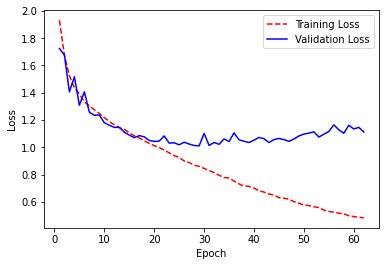

In [22]:

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
with open ("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")



# # test on Public-test dataset
# print('Test performance in Public set')
# y_pre = loaded_model.predict(X_testPub)
# print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))
# print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))

# test on Private-test dataset
print('Test performance in Private set')
y_pre = loaded_model.predict(X_testPrivate)

print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1)))
print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1) ))

Test performance in Private set
              precision    recall  f1-score   support

           0       0.55      0.63      0.58       477
           1       0.34      0.46      0.39       392
           2       0.88      0.84      0.86       914
           3       0.48      0.51      0.50       564
           4       0.69      0.80      0.74       357
           5       0.77      0.54      0.64       885

    accuracy                           0.64      3589
   macro avg       0.62      0.63      0.62      3589
weighted avg       0.67      0.64      0.65      3589

0.6422401783226526
